
# ハチと蟻の識別器

このファイルはGoogle Colaboratory上での実行を前提としています。


In [ ]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
w = !apt install tree
print(w[-2])

tree is already the newest version (1.7.0-5).


In [ ]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [ ]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**共通関数の読み込み**

In [ ]:
# 損失計算用
def eval_loss(loader, device, net, criterion):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc.cpu(), avg_val_loss, avg_val_acc.cpu()])
        history = np.vstack((history, item))
    return history

    # 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

    # イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## データ準備

[URL](https://download.pytorch.org/tutorial/hymenoptera_data.zip)からファイルをダウンロードすることができますが、Google Colabのランタイムがリセットされるたびにアップロードが必要なため、
コマンドでダウンロードと解凍ができるようにしておきます。

### サンプルデータのダウンロード・解凍

In [ ]:
# サンプルデータのダウンロード
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 結果確認
print(w[-2])

File ‘hymenoptera_data.zip’ already there; not retrieving.


In [ ]:
# データ解凍
w = !unzip -o hymenoptera_data.zip

# 結果確認
print(w[-1])

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [ ]:
# 解凍ファイルのtree表示
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

ダウンロードしたファイルは、「train」と「val」という名前のフォルダにそれぞれ「ants」と「bees」というフォルダが入っている。

### データ前処理

入力するネットワークに合わせて画像を加工する。

転移学習とファインチューニングを利用した。

In [ ]:
# Transforms定義
# 訓練データ用:
train_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.10), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 検証データ用:
test_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
])


### データセット定義

`datasets.ImageFolder`の第一引数にフォルダパスを渡すと、そのフォルダ以下のフォルダ名をラベルとして画像を読み込みます。

In [ ]:
# ベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [ ]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)

# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


### データ確認

訓練データの最初の10個と最後の10個を表示する。

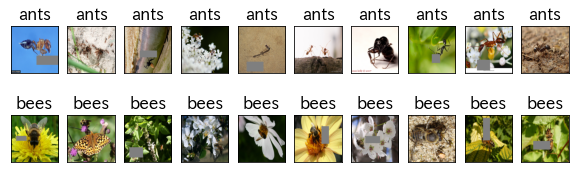

In [ ]:
# 検証データ　
# 最初の10個と最後の10個の表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    # image と labelの取得
    if i < 10:
      image, label = train_data[i]
    else:
      image, label = train_data[-(i-9)]
    image = np.transpose(image, (1, 2, 0))
    image = (image + 1)/2
    label = classes[label]
    # イメージ表示
    plt.imshow(image)
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

###  ミニバッチ作成

In [ ]:
# データローダー定義

# バッチサイズ定義
batch_size = 50

# 訓練用
train_loader = DataLoader(
    train_data, batch_size = batch_size, 
    shuffle = True)

# 検証用
test_loader = DataLoader(
    test_data, batch_size = batch_size, 
    shuffle = False)


### モデル定義

In [ ]:
# 学習モデル定義
from torchvision import models

torch_seed()

#ResNet50を使用した
#今回データが少なかったため、層の数は多くなくて良いと判断
net = models.resnet50(pretrained = True)

# 最終レイヤー関数の入力次元数を確認
fc_in_features = net.fc.in_features

# 最終レイヤー関数の付け替え
n_output = len(classes)
net.fc = nn.Linear(fc_in_features, n_output)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# Adagradを用いた
optimizer = optim.Adagrad(net.parameters(), lr=lr)


###  学習

In [ ]:
# historyファイルも同時に初期化する
history = np.zeros((0, 5))

# 学習
num_epochs = 5

history = fit(net, optimizer, criterion, num_epochs, 
        train_loader, test_loader, device, history)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.01303 acc: 0.71311 val_loss: 0.03595, val_acc: 0.70588


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00565 acc: 0.88115 val_loss: 0.01392, val_acc: 0.78431


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00330 acc: 0.93033 val_loss: 0.00661, val_acc: 0.92157


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00389 acc: 0.89754 val_loss: 0.00629, val_acc: 0.92157


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00072 acc: 1.00000 val_loss: 0.00599, val_acc: 0.92157


初期状態: 損失: 0.03595 精度: 0.70588
最終状態: 損失: 0.00599 精度: 0.92157


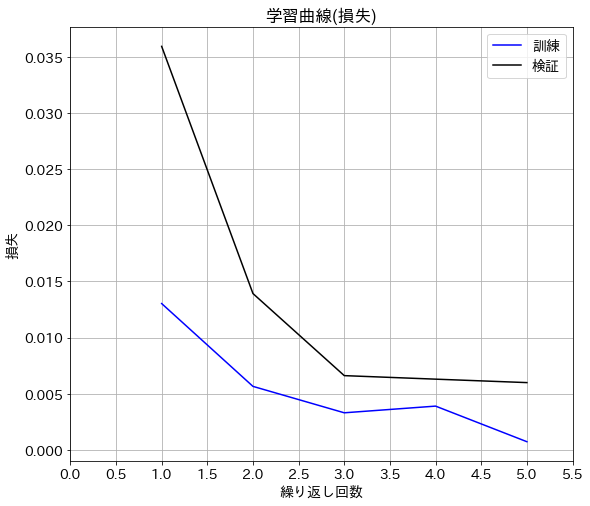

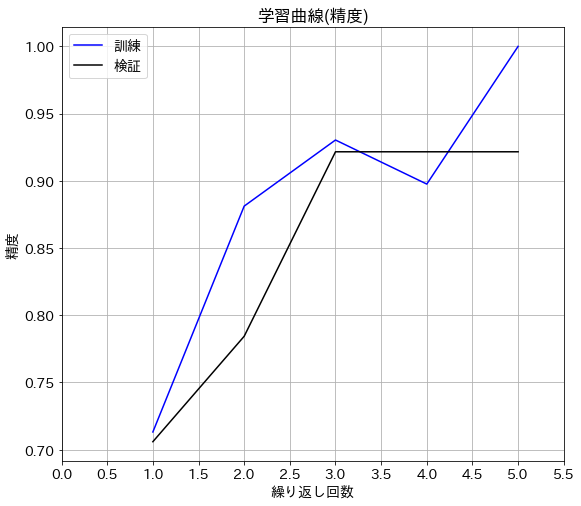

In [ ]:
# 結果確認 図示

evaluate_history(history)

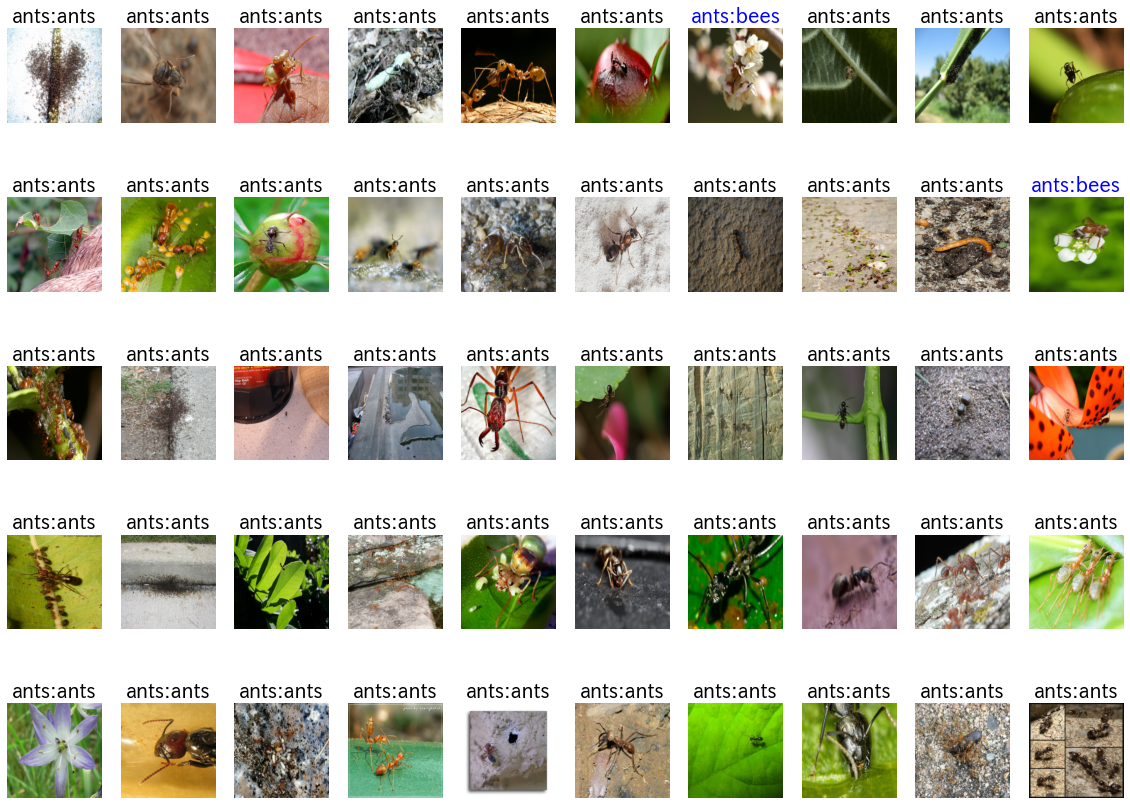

In [ ]:
# 検証データへの結果表示
# イメージと正解・予測結果の表示
show_images_labels(test_loader, classes, net, device)

#### モデルの保存

In [ ]:
# エラー防止のため一旦CPUにモデルを移動
net.cpu()

# パラメータ保存
netparam_path =  "net.prm"
torch.save(net.state_dict(), netparam_path)